In [1]:
%reset

In [2]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

## Load dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [4]:
DATA_PATH = "../data/trafic_32"
dataset = datasets.ImageFolder(root=DATA_PATH)
custom_dataset = CustomDataset(dataset, transform=transforms.ToTensor())

## Get dataset mean and std 

In [8]:
from torchvision import transforms
batch_size = 32


def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = torch.zeros(3)   
    std = torch.zeros(3)
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        for i in range(num_channels):
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(loader))
    std.div_(len(loader))
    print(mean, std)

    return mean, std

loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers = 6, drop_last=True)
mean, std = get_mean_std(loader)

tensor([0.3185, 0.2930, 0.3016]) tensor([0.2736, 0.2630, 0.2662])


In [9]:
mean

tensor([0.3185, 0.2930, 0.3016])

In [10]:
std

tensor([0.2736, 0.2630, 0.2662])

In [11]:
transform_train = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(0.3),
        # transforms.RandomVerticalFlip(0.3),
        # transforms.RandomRotation(15),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        # transforms.RandomErasing(0.1),
        # transforms.GaussianBlur(1.0),
        transforms.Normalize(mean=mean, std=std),
    ]
)
transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

## Split dataset

In [12]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(
    range(len(dataset)), [n_train_examples, n_val_examples]
)
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [13]:
batch_size = 256

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=6
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=6)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1090, 274])


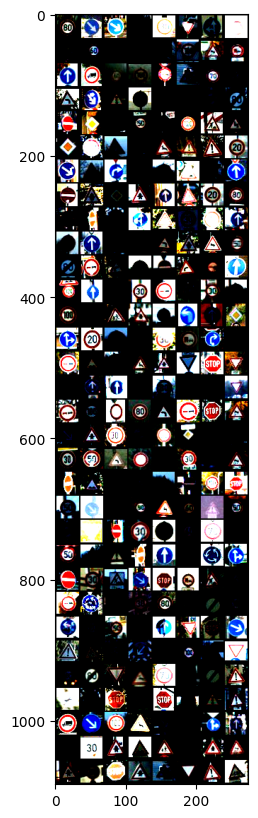

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))
def unnormalize(img):
    for channel in range(3):
        img[channel] = (img[channel] * std[channel]) + mean[channel]  # unnormalize
    return img

def imshow(img):
    print(img.shape)
    # img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

# Encoder


In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

# Decoder


In [30]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat

# VAE


In [18]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(
            input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim
        )

    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = eps * var + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(
            mean, torch.exp(0.5 * log_var)
        )  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

# VAE training

In [31]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=3072).to(device)

In [28]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [21]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [34]:
num_epochs = 2
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()  # backward pass (compute parameter updates)
        optimizer.step()  # make the updates for each parameter
        optimizer.zero_grad()
        break
    L1_list = []
    #     if n % 10 == 0:
    for x, _ in iter(val_loader):
        x = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(
        f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}"
    )
    scheduler.step()

Epoch 0 loss 1035158.25, test L1 = 1.0026306197291515
Epoch 1 loss 1003301.1875, test L1 = 1.0026314248804187


## Reconstructions|

In [38]:
def get_train_images(num):
    return torch.stack([custom_dataset[i][0] for i in range(10, 10 + num)], dim=0)

In [42]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

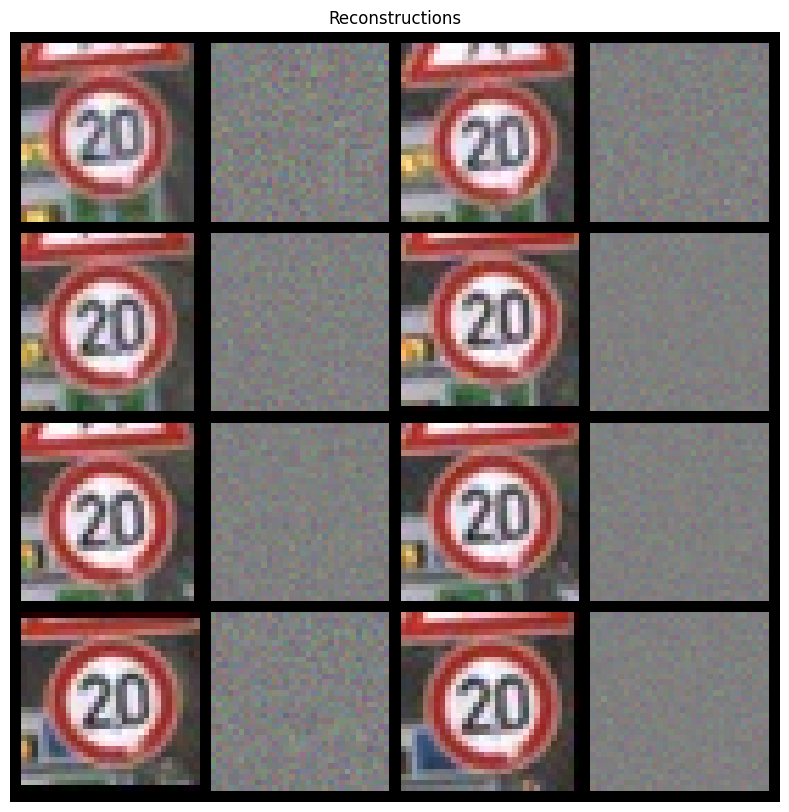

In [43]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

## Generate images

In [46]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(
            torch.randn([n_imgs, model.latent_dim]).to(device)
        )
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(
        generated_imgs, nrow=4, normalize=False
    )
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

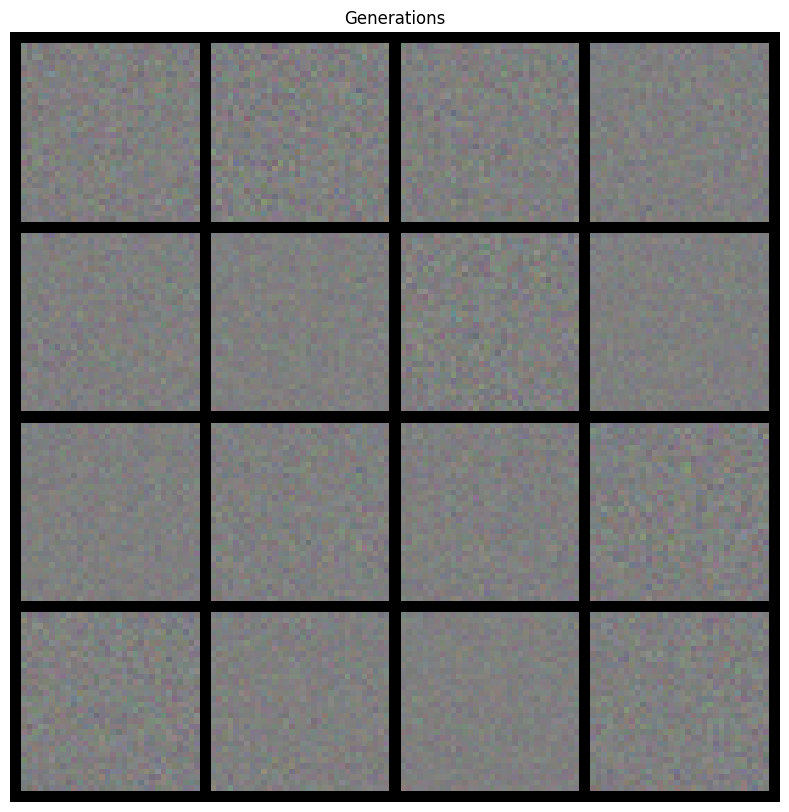

In [47]:
generate_images(vae, 16, device)

# Evaluator

In [76]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out = nn.Linear(50, 43)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x


evaluator = Evaluator(32 * 32 * 3, 256).to(device)

# Fretchet distance

In [53]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [57]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [78]:
num_epochs = 1
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        print(targets.shape)

        results = evaluator(data)
        print(results.shape)
        

        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        break

torch.Size([256])
torch.Size([256, 43])


In [79]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(val_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)
        break

print("Correctly guessed ", num_correct / total_guesses * 100, "% of the dataset")

Correctly guessed  0.390625 % of the dataset


In [81]:
latent_dim = 16

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    generations_vae = vae.decoder(fixed_noise)

In [83]:
orig_data = [x[0] for x in list(dataset)[:10]]
orig_data = torch.cat(orig_data)

TypeError: expected Tensor as element 0 in argument 0, but got Image

In [ ]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()

In [ ]:
orig_data_2 = [x[0] for x in list(dataset)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()